In [15]:
import os
import json
from pathlib import Path
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from PIL import Image
from tqdm.auto import tqdm


### Configuration Constants
Defines dataset paths, device/model settings, PGD attack parameters, and DataLoader configs enabling structured control over adversarial image generation and evaluation.


This cell sets all the necessary configuration constants for the experiment:

- **Paths**:
  - Define paths for the **original dataset**, **label file**, and the **three adversarial datasets**.

- **Device and Weights**:
  - Set the **computation device** to GPU if available, otherwise CPU.
  - Define the **pre-trained weight version** for ResNet-34 (`IMAGENET1K_V1`).

- **PGD Attack Parameters**:
  - Specifie **epsilon, alpha, and iterations** for the PGD attack.  
  - These parameters are used in earlier tasks and remain relevant for evaluation.

- **DataLoader Parameters**:
  - Define the **batch size** and **number of workers** for efficient data loading and batch processing.


In [16]:
# CONFIGURATION CONSTANTS


# --- PATHS ---
DATASET_PATH = "../TestDataSet" 
LABEL_JSON_PATH = os.path.join(DATASET_PATH, "labels_list.json") 
ADV_DATASET_PATH_TASK1 = "../Adversarial_Test_Set_1"  # Output path for adversarial set 1
ADV_DATASET_PATH_TASK2 = "../AdversarialTestSet2_PGD_Refactored"  # Output path for adversarial set 2
ADV_DATASET_PATH_TASK3 = "../Adversarial_Test_Set_3"  # Output path for adversarial set 3

# --- MODEL & DEVICE ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WEIGHTS = "IMAGENET1K_V1"

# --- PGD ATTACK PARAMETERS ---
EPSILON = 0.02        # Maximum L∞-norm perturbation
PGD_ALPHA = 0.005     # PGD step size
PGD_ITERS = 5         # Number of PGD iterations

# --- DATALOADER PARAMETERS ---
BATCH_SIZE = 32
NUM_WORKERS = 0


### Dataset Preprocessing and Custom Loader
Loads ground-truth ImageNet indices from JSON, maps class folders to correct labels, and reassigns orig_folder labels accordingly. Defines AdvDataset to load and transform adversarial .png images with their true labels for consistent evaluation.

### Label Mapping Preparation

This cell reads the `labels_list.json` file containing label information:

- **Processing**:
  - Extracts the **true ImageNet indices** by splitting each string entry in the JSON and converting the first part to an integer.
  
- **Purpose**:
  - Creates the `true_imagenet_indices` list, which will be used to **remap labels correctly when evaluating adversarial images**, ensuring alignment with ImageNet standards.


In [17]:
with open(LABEL_JSON_PATH, "r") as file:
    label_lines = json.load(file)

true_imagenet_indices = [int(entry.split(":")[0]) for entry in label_lines]


In [18]:
orig_folder = ImageFolder(root=DATASET_PATH, transform=None)

folder_to_imagenet_index = {
    class_name: true_imagenet_indices[idx]
    for idx, class_name in enumerate(orig_folder.classes)
}

orig_folder.samples = [
    (
        image_path,
        folder_to_imagenet_index[os.path.basename(os.path.dirname(image_path))]
    )
    for image_path, _ in orig_folder.samples
]



In [19]:
orig_folder.samples.sort(key=lambda sample: sample[0])
orig_labels = [label for _, label in orig_folder.samples]


### Custom Adversarial Dataset Loading

- **Custom Dataset**:  
  Loads adversarial images (`.png` files) from the specified folder.

- **Label Handling**:  
  Uses the same **labels list** for all adversarial sets, assuming they correspond to the same images as the original dataset.

- **Transformations**:  
  Applies the correct preprocessing transforms to ensure the adversarial images are **compatible with ImageNet models** for evaluation.


In [20]:
class AdvDataset(Dataset):
    def __init__(self, image_dir, true_labels, transform=None):
        self.image_paths = sorted(
            os.path.join(image_dir, filename)
            for filename in os.listdir(image_dir)
            if filename.endswith(".png")
        )
        if len(self.image_paths) != len(true_labels):
            raise ValueError(
                f"Mismatch: {len(self.image_paths)} images vs {len(true_labels)} labels"
            )

        self.labels = true_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.labels[index]
        return image, label


### Dataset Loading and Preprocessing

- **Transforms**:  
  Applies standard preprocessing for ImageNet models, including resizing, center cropping, tensor conversion, and normalization.

- **Loading Dataset**:  
  Uses `ImageFolder` to load the dataset from the specified directory.

- **Re-mapping Labels**:  
  Maps class folders to the correct ImageNet indices using the previously loaded `true_imagenet_indices`.

- **Loader Creation**:  
  Creates the `clean_loader` to enable batch-wise iteration over the clean dataset with corrected labels.


In [21]:
# --- Input Normalization ---
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# --- Dataset Paths ---
paths = {
    "Original": DATASET_PATH,
    "FGSM": ADV_DATASET_PATH_TASK1,
    "PGD": ADV_DATASET_PATH_TASK2,
    "Patch": ADV_DATASET_PATH_TASK3,
}

### Model Initialization
Selects GPU if available, else CPU, and loads a pretrained DenseNet-121 model with ImageNet weights, setting it to evaluation mode and moving it to the selected device

In [22]:
# --- Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [23]:
# --- Load Pretrained Model ---
new_model = models.densenet121(weights="IMAGENET1K_V1")
new_model.eval().to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### Evaluation Loop and Accuracy Metrics
Defines an evaluate function to compute Top-1 and Top-5 accuracy using topk predictions. Iterates through each dataset (original and adversarial), loads it with transformations, evaluates using DenseNet-121, and stores the accuracy results

### Evaluation Function

- **Function Purpose**:  
  Defines a reusable evaluation function for **any dataset and model**.

- **Key Steps**:
  - Uses `torch.no_grad()` to disable gradient computation, enabling **faster and memory-efficient inference**.
  - Iterates over batches, computes model outputs.
  - Calculates **Top-1 and Top-5 accuracy** using the previously defined helper function.
  
- **Output**:
  - Returns the computed **accuracy scores as percentages**, providing a quantitative measure of model performance.


In [24]:
def evaluate(model, data_loader):
    top1_correct = top5_correct = total_samples = 0

    with torch.no_grad():
        for images, labels in tqdm(data_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, top1_preds = outputs.topk(1, dim=1)
            _, top5_preds = outputs.topk(5, dim=1)

            top1_correct += (top1_preds.squeeze() == labels).sum().item()
            top5_correct += sum([labels[i] in top5_preds[i] for i in range(len(labels))])
            total_samples += images.size(0)

    top1_accuracy = 100 * top1_correct / total_samples
    top5_accuracy = 100 * top5_correct / total_samples

    return top1_accuracy, top5_accuracy


In [25]:
evaluation_results = {}

for dataset_name, dataset_path in paths.items():
    if dataset_name == "Original":
        dataset = orig_folder
        dataset.transform = transform
    else:
        dataset = AdvDataset(dataset_path, orig_labels, transform)

    data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    print(f"\nEvaluating {dataset_name} dataset on DenseNet-121:")
    top1_accuracy, top5_accuracy = evaluate(new_model, data_loader)
    evaluation_results[dataset_name] = (top1_accuracy, top5_accuracy)

    print(f"Top-1: {top1_accuracy:.2f}%   Top-5: {top5_accuracy:.2f}%")



Evaluating Original dataset on DenseNet-121:


100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Top-1: 74.60%   Top-5: 93.60%

Evaluating FGSM dataset on DenseNet-121:


100%|██████████| 16/16 [00:06<00:00,  2.30it/s]


Top-1: 35.80%   Top-5: 59.60%

Evaluating PGD dataset on DenseNet-121:


100%|██████████| 16/16 [00:06<00:00,  2.48it/s]


Top-1: 39.00%   Top-5: 64.40%

Evaluating Patch dataset on DenseNet-121:


100%|██████████| 16/16 [00:06<00:00,  2.65it/s]

Top-1: 41.80%   Top-5: 65.60%


### Accuracy Visualization

Generates a grouped bar chart comparing Top-1 and Top-5 accuracies of DenseNet-121 across Original, PGD, and Patch datasets. Annotates bars with exact values, labels axes, and uses distinct colors for clarity in performance comparison.


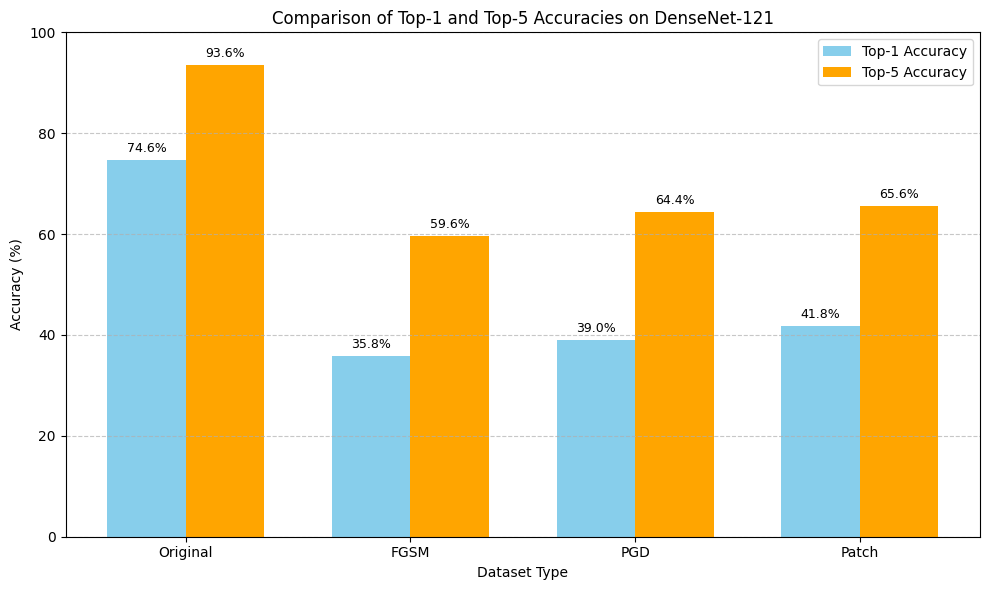

In [26]:
import matplotlib.pyplot as plt

# Evaluation results from model testing
evaluation_results = {
    "Original": (74.6, 93.6),
    "FGSM": (35.8, 59.6),
    "PGD": (39.0, 64.4),
    "Patch": (41.8, 65.6)
}


# Extract dataset names and accuracy values
datasets = list(evaluation_results.keys())
top1_accuracies = [evaluation_results[ds][0] for ds in datasets]
top5_accuracies = [evaluation_results[ds][1] for ds in datasets]

# Bar width and positions
x = range(len(datasets))
bar_width = 0.35

# Create the plot
plt.figure(figsize=(10, 6))
bars1 = plt.bar(x, top1_accuracies, width=bar_width, label='Top-1 Accuracy', color='skyblue')
bars2 = plt.bar([i + bar_width for i in x], top5_accuracies, width=bar_width, label='Top-5 Accuracy', color='orange')

# Annotate bars with values
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# Set plot details
plt.xlabel('Dataset Type')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Top-1 and Top-5 Accuracies on DenseNet-121')
plt.xticks([i + bar_width / 2 for i in x], datasets)
plt.ylim(0, 100)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


### Key Insights

#### Original Dataset (Clean Images)
- DenseNet-121 performs strongly on clean images.
- **Top-1 Accuracy**: 74.6%  
- **Top-5 Accuracy**: 93.6%  
- Serves as the baseline performance.

#### FGSM Attack
- **Top-1 Accuracy** drops to 35.8%, **Top-5 Accuracy** to 59.6%.
- Despite being a single-step attack, FGSM heavily degrades performance.
- Shows high transferability from ResNet-generated adversarial examples to DenseNet-121.

#### PGD Attack
- **Top-1 Accuracy**: 39%, **Top-5 Accuracy**: 64.4%.
- This outcome may result from specific PGD settings (e.g., $\epsilon$, iterations).
- Still causes severe misclassification, showing strong transferability.

#### Patch Attack (Localized)
- **Top-1 Accuracy**: 41.8%, **Top-5 Accuracy**: 65.6%.
- Better than FGSM and PGD, but still significantly degrades performance.
- Despite being localized to a small 32x32 patch, the attack is highly effective.
- Demonstrates the potency of localized perturbations, even though the rest of the image remains clean.


### Conclusion 

- **Transferability Across Models**:  
  Adversarial examples crafted (likely for ResNet-34) also severely degrade DenseNet-121's performance, confirming that **adversarial attacks are transferable across architectures, not just model-specific.

- **PGD and FGSM Trends**:  
  Both attacks cause drastic reductions in model reliability.  
  Surprisingly, FGSM performed better than PGD.

- **Effectiveness of Patch Attacks**:  
  Despite the localized nature of patch attacks, they remain highly effective, successfully exploiting vulnerabilities and leading to significant misclassifications.
